# Tutorial for quante_carlo
- <b>quante_carlo</b> is a multiprocess hyperparameter tuning module. 
- This notebook demonstrates how to use this module to determine the number of neurons to use in a pytorch neural network.

In [3]:
#from sklearn.model_selection import cross_val_score
import pandas as pd
#from quante_carlo import quante
import quante
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
import time
import numpy as np
import torch
import multiprocessing as mp
from torch import nn

In [2]:
cd ../quante_carlo

/home/ec2-user/SageMaker/projects/quante_carlo/quante_carlo


In [4]:
import worker

In [14]:
torch.cuda.device_count()

4

In [5]:
mp.set_start_method('spawn')

## This tutorial uses mnist dataset available <a href="https://www.kaggle.com/code/imdevskp/digits-mnist-classification-using-cnn">here</a>

Included with this repository is a file named worked.py. Inside that file is a It's better to put the function you want to tune in a file.

In [9]:
if __name__ == '__main__':

    
    hp_tune = quante.carlo(worker.instance, limits=[[64, 1024], [64, 1024], [64, 1024]], 
                           kernel=DotProduct()+ WhiteKernel(), 
                           gpr_batch_size=100, n_processors=4, n_iterations=100, 
                           other_parameters ={'input_layer_size': 28*28, 
                                              'output_layer_size': 10, 
                                              'train_iterations': 100,
                                              'n_batches': 5,
                                              'batch_size': .05})
    p = mp.Pool()
    start = time.time()    
    session = hp_tune(p)

    print("{} seconds".format(round(time.time() - start,2)))
    p.close()
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 3 has a total capacity of 14.58 GiB of which 21.62 MiB is free. Process 504 has 448.00 MiB memory in use. Process 507 has 448.00 MiB memory in use. Process 506 has 448.00 MiB memory in use. Process 505 has 448.00 MiB memory in use. Process 511 has 414.00 MiB memory in use. Process 509 has 414.00 MiB memory in use. Process 508 has 414.00 MiB memory in use. Process 510 has 414.00 MiB memory in use. Process 515 has 384.00 MiB memory in use. Process 512 has 384.00 MiB memory in use. Process 514 has 384.00 MiB memory in use. Process 513 has 384.00 MiB memory in use. Process 517 has 450.00 MiB memory in use. Process 519 has 450.00 MiB memory in use. Process 518 has 450.00 MiB memory in use. Process 516 has 450.00 MiB memory in use. Process 520 has 556.00 MiB memory in use. Process 527 has 556.00 MiB memory in use. Process 526 has 556.00 MiB memory in use. Process 521 has 556.00 MiB memory in use. Process 522 has 432.00 MiB memory in use. Process 534 has 432.00 MiB memory in use. Process 524 has 432.00 MiB memory in use. Process 523 has 432.00 MiB memory in use. Process 535 has 344.00 MiB memory in use. Process 529 has 344.00 MiB memory in use. Process 528 has 344.00 MiB memory in use. Process 525 has 344.00 MiB memory in use. Process 532 has 496.00 MiB memory in use. Process 530 has 496.00 MiB memory in use. Process 531 has 496.00 MiB memory in use. Process 537 has 496.00 MiB memory in use. Including non-PyTorch memory, this process has 260.00 MiB memory in use. Process 539 has 180.00 MiB memory in use. Process 533 has 180.00 MiB memory in use. Process 538 has 180.00 MiB memory in use. Of the allocated memory 99.59 MiB is allocated by PyTorch, and 26.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
summary = session.summary()

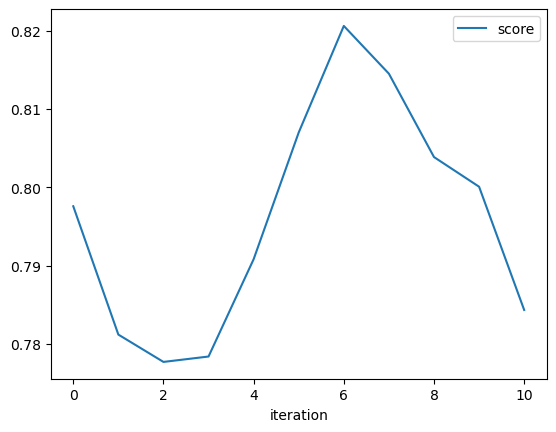

In [8]:
n = summary[['score', 'iteration']].groupby('iteration').max().plot()

In [19]:
import matplotlib.pyplot as plt

In [8]:
session.score_history

[0.8236023038625717,
 0.8264149278402328,
 0.8296274244785309,
 0.8335081189870834,
 0.7914711236953735,
 0.8246472775936127,
 0.807355597615242,
 0.8046178221702576,
 0.819714367389679,
 0.8345688283443451,
 0.8248534500598907,
 0.8242157548666,
 0.8154868185520172,
 0.801821231842041,
 0.8148841857910156,
 0.8318903148174286,
 0.7927335798740387,
 0.7842507362365723,
 0.8249311298131943,
 0.790860503911972,
 0.8301946967840195,
 0.8338319063186646,
 0.8203210383653641,
 0.818184569478035]

In [9]:
session.y_best

0.8345688283443451

In [10]:
summary

,iteration,score,hparameters,qEi
0,0,0.823602,"(68, 119, 90)",-1.000000
1,0,0.826415,"(70, 125, 65)",-1.000000
2,0,0.829627,"(79, 83, 118)",-1.000000
3,0,0.833508,"(69, 92, 127)",-1.000000
4,1,0.791471,"(64, 127, 121)",0.997644
5,1,0.824647,"(76, 91, 84)",0.997644
6,1,0.807356,"(113, 107, 123)",0.997644
7,1,0.804618,"(69, 80, 107)",0.997644
8,2,0.819714,"(67, 68, 81)",0.830046
9,2,0.834569,"(69, 123, 126)",0.830046
